KUC Hackathon Winter 2018 : What can you do with the Drug Review dataset?:

 TEAM EDA's second project, following the last Beginer challenge: House price Advanced Regression (https://www.kaggle.com/chocozzz/beginner-challenge-house-prices) . The Drug Review dataset on the link (https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018).

![](http://cfile29.uf.tistory.com/image/996BDD3B5BFF269023E706)

This is a hackathon for college students who are playing kaggle, but it is not a objective but make a objective for each team. Personally, this is the first time I have ever been in the field of natural language processing. If you see a strange part,  leave a comment , I will try to study and revise it.

---

Our team *Recommendation Medicines : Using a review* that fit the patient's condition. The process proceeds in the order of **data exploration  - data preprocessing - model - conclusion - limit**. In the data exploration part, we will look at data types with visualization techniques and statistical techniques. Through this process, we can set the topic, preprocess the data to fit the objective, and create various variables to fit model.  At the model part, emotion analysis using word dictionary, n-gram applying deep learning, etc. were used. In order to compensate the limitation of natural language processing, Lightgbm machine learning model was used and reliability was further secured through usefulcount. Finally, I will introduce the limitations and weak points of conclusion and analysis of the project.

---

Team Information
- Member names : Hyunwoo Kim, Juyeon Park, Jiye Lee, Eunjoo Min, Sumin Song.
- University name : Hayang University.
- Club name : TEAM-EDA.
- Team name : TEAM-EDA.

In [2]:
!pip install transformers plotly

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/kuc-hackathon-winter-2018")

print("Path to dataset files:", path)

100%|██████████| 40.7M/40.7M [00:02<00:00, 14.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/kuc-hackathon-winter-2018/versions/2


In [4]:
import pandas as pd #Analysis
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis
from scipy.stats import norm #Analysis
from sklearn.preprocessing import StandardScaler #Analysis
from scipy import stats #Analysis
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

import os
import string
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

import torch
from transformers import BertTokenizer, BertModel
from plotly.subplots import make_subplots

## 1. Exploration Data Analysis

### 1.1. Data understanding


First we will import Train data and Test data. The sizes of the two data are as follows:

It was data from https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29 and crawled reviews from online pharmaceutical review sites.

In [5]:
import os
print(os.listdir("/root/.cache/kagglehub/datasets/jessicali9530/kuc-hackathon-winter-2018/versions/2"))

['drugsComTest_raw.csv', 'drugsComTrain_raw.csv']


In [6]:
df_train = pd.read_csv("/root/.cache/kagglehub/datasets/jessicali9530/kuc-hackathon-winter-2018/versions/2/drugsComTrain_raw.csv", parse_dates=["date"])
df_test = pd.read_csv("/root/.cache/kagglehub/datasets/jessicali9530/kuc-hackathon-winter-2018/versions/2/drugsComTest_raw.csv", parse_dates=["date"])

In [7]:
print("Train shape :" ,df_train.shape)
print("Test shape :", df_test.shape)

Train shape : (161297, 7)
Test shape : (53766, 7)


This is the result of looking at the data through the head () command. There are six variables except for the unique ID that identifies the individual, and review is the key variable.

In [8]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37


These are additional explanations for variables.

- drugName (categorical): name of drug
- condition (categorical): name of condition
- review (text): patient review
- rating (numerical): 10 star patient rating
- date (date): date of review entry
- usefulCount (numerical): number of users who found review useful

The structure of the data is that a patient with a unique ID purchases a drug that meets his condition and writes a review and rating for the drug he/she purchased on the date. Afterwards, if the others read that review and find it helpful, they will click usefulCount, which will add 1 for the variable.

### 1.2. Data understanding

First, we will start exploring variables, starting from uniqueID. We compared the unique number of unique IDs and the length of the train data to see if the same customer has written multiple reviews, and there weren't more than one reviews for one customer.

In [9]:
print("unique values count of train : " ,len(set(df_train['uniqueID'].values)))
print("length of train : " ,df_train.shape[0])

unique values count of train :  161297
length of train :  161297


DrugName is closely related to condition, so we have analyzed them together. The unique values of the two variables are 3671 and 917, respectively, and there are about 4 drugs for each condition. Let's go ahead and visualize this in more detail.

In [10]:
df_all = pd.concat([df_train,df_test])

Text(0.5, 1.0, 'Top20 : The number of drugs per condition.')

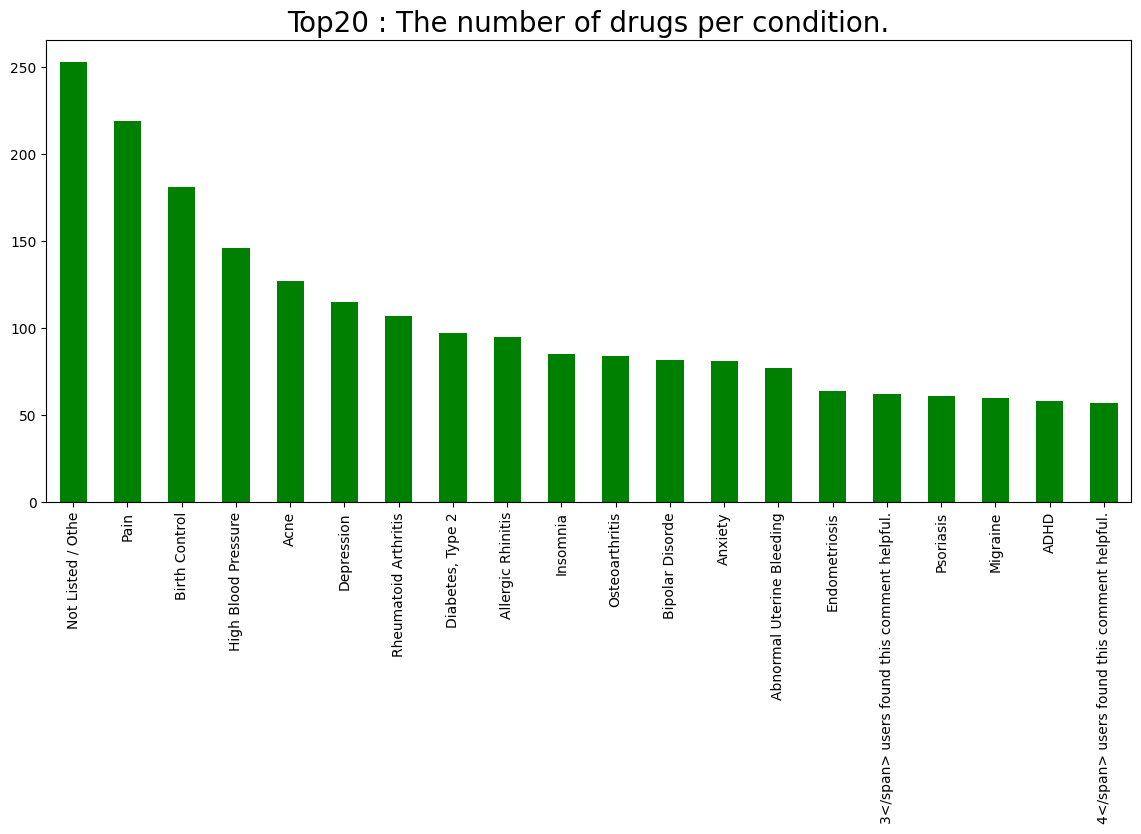

In [11]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top20 : The number of drugs per condition.", fontsize = 20)

As you can see from the picture above, the number of drugs for top eight conditions is about 100 for each condition. On the other hand, it should be noted that the phrase "3</span> users found this comment helpful" appears in the condition, which seems like an error in the crawling process. I have looked into it to see in more details.

In [12]:
df_all[df_all['condition']=='3</span> users found this comment helpful.'].head(3)

,uniqueID,drugName,condition,review,rating,date,usefulCount
243,81588,Yaz,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a...",3,2010-06-01,3
1864,124318,Skyla,3</span> users found this comment helpful.,"""Never pregnant,28,retroverted small (6cm) ute...",1,2015-12-16,3
3322,202848,ProAir HFA,3</span> users found this comment helpful.,"""I get chest colds and asthmatic symptoms in t...",9,2015-12-12,3


It is expected that for structure of '</ span> users found this comment helpful.' phrase, there will be not only 3, but also 4 as shown above, and other numbers as well. We will remove these data in the future preprocessing.

The following are the low 20 conditions of 'drugs per condition'. As you can see, the number is all 1. Considering the recommendation system, it is not feasible to recommend with that when there is only one product. Therefore, we will analyze only the conditions that have at least 2 drugs per condition.

Text(0.5, 1.0, 'Bottom20 : The number of drugs per condition.')

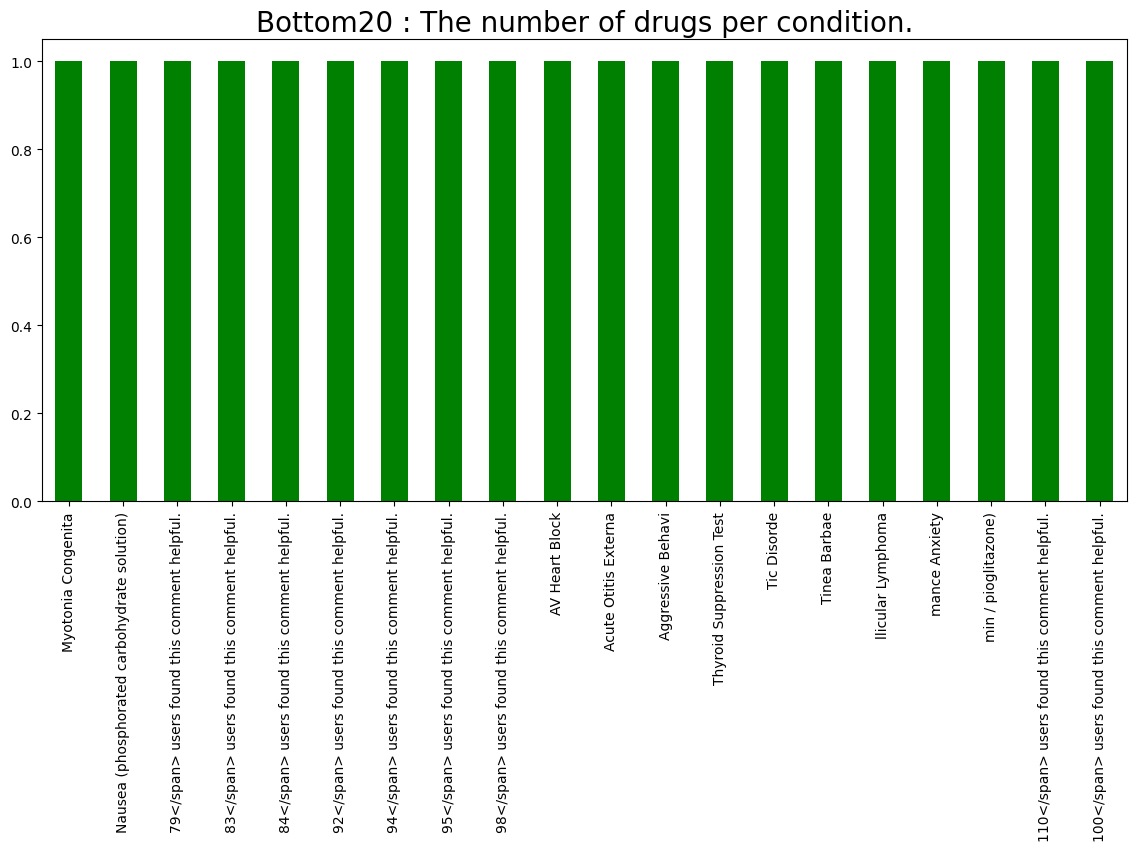

In [13]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)

condition_dn[condition_dn.shape[0]-20:condition_dn.shape[0]].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Bottom20 : The number of drugs per condition.", fontsize = 20)

Next, let's have a look at the review. First, noticeable parts are the html strings like \ r \ n, and the parts that express emotions in parentheses such as (very unusual for him) and (a good thing) and words in capital letters like MUCH.

In [14]:
df_train['review'][1]

'"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective."'

In addition, there were some words with errors like didn&# 039;t for didn't, and also characters like ...

In [15]:
df_train['review'][2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

We will delete these parts in preprocessing as well.

Next up, it's Word Cloud.

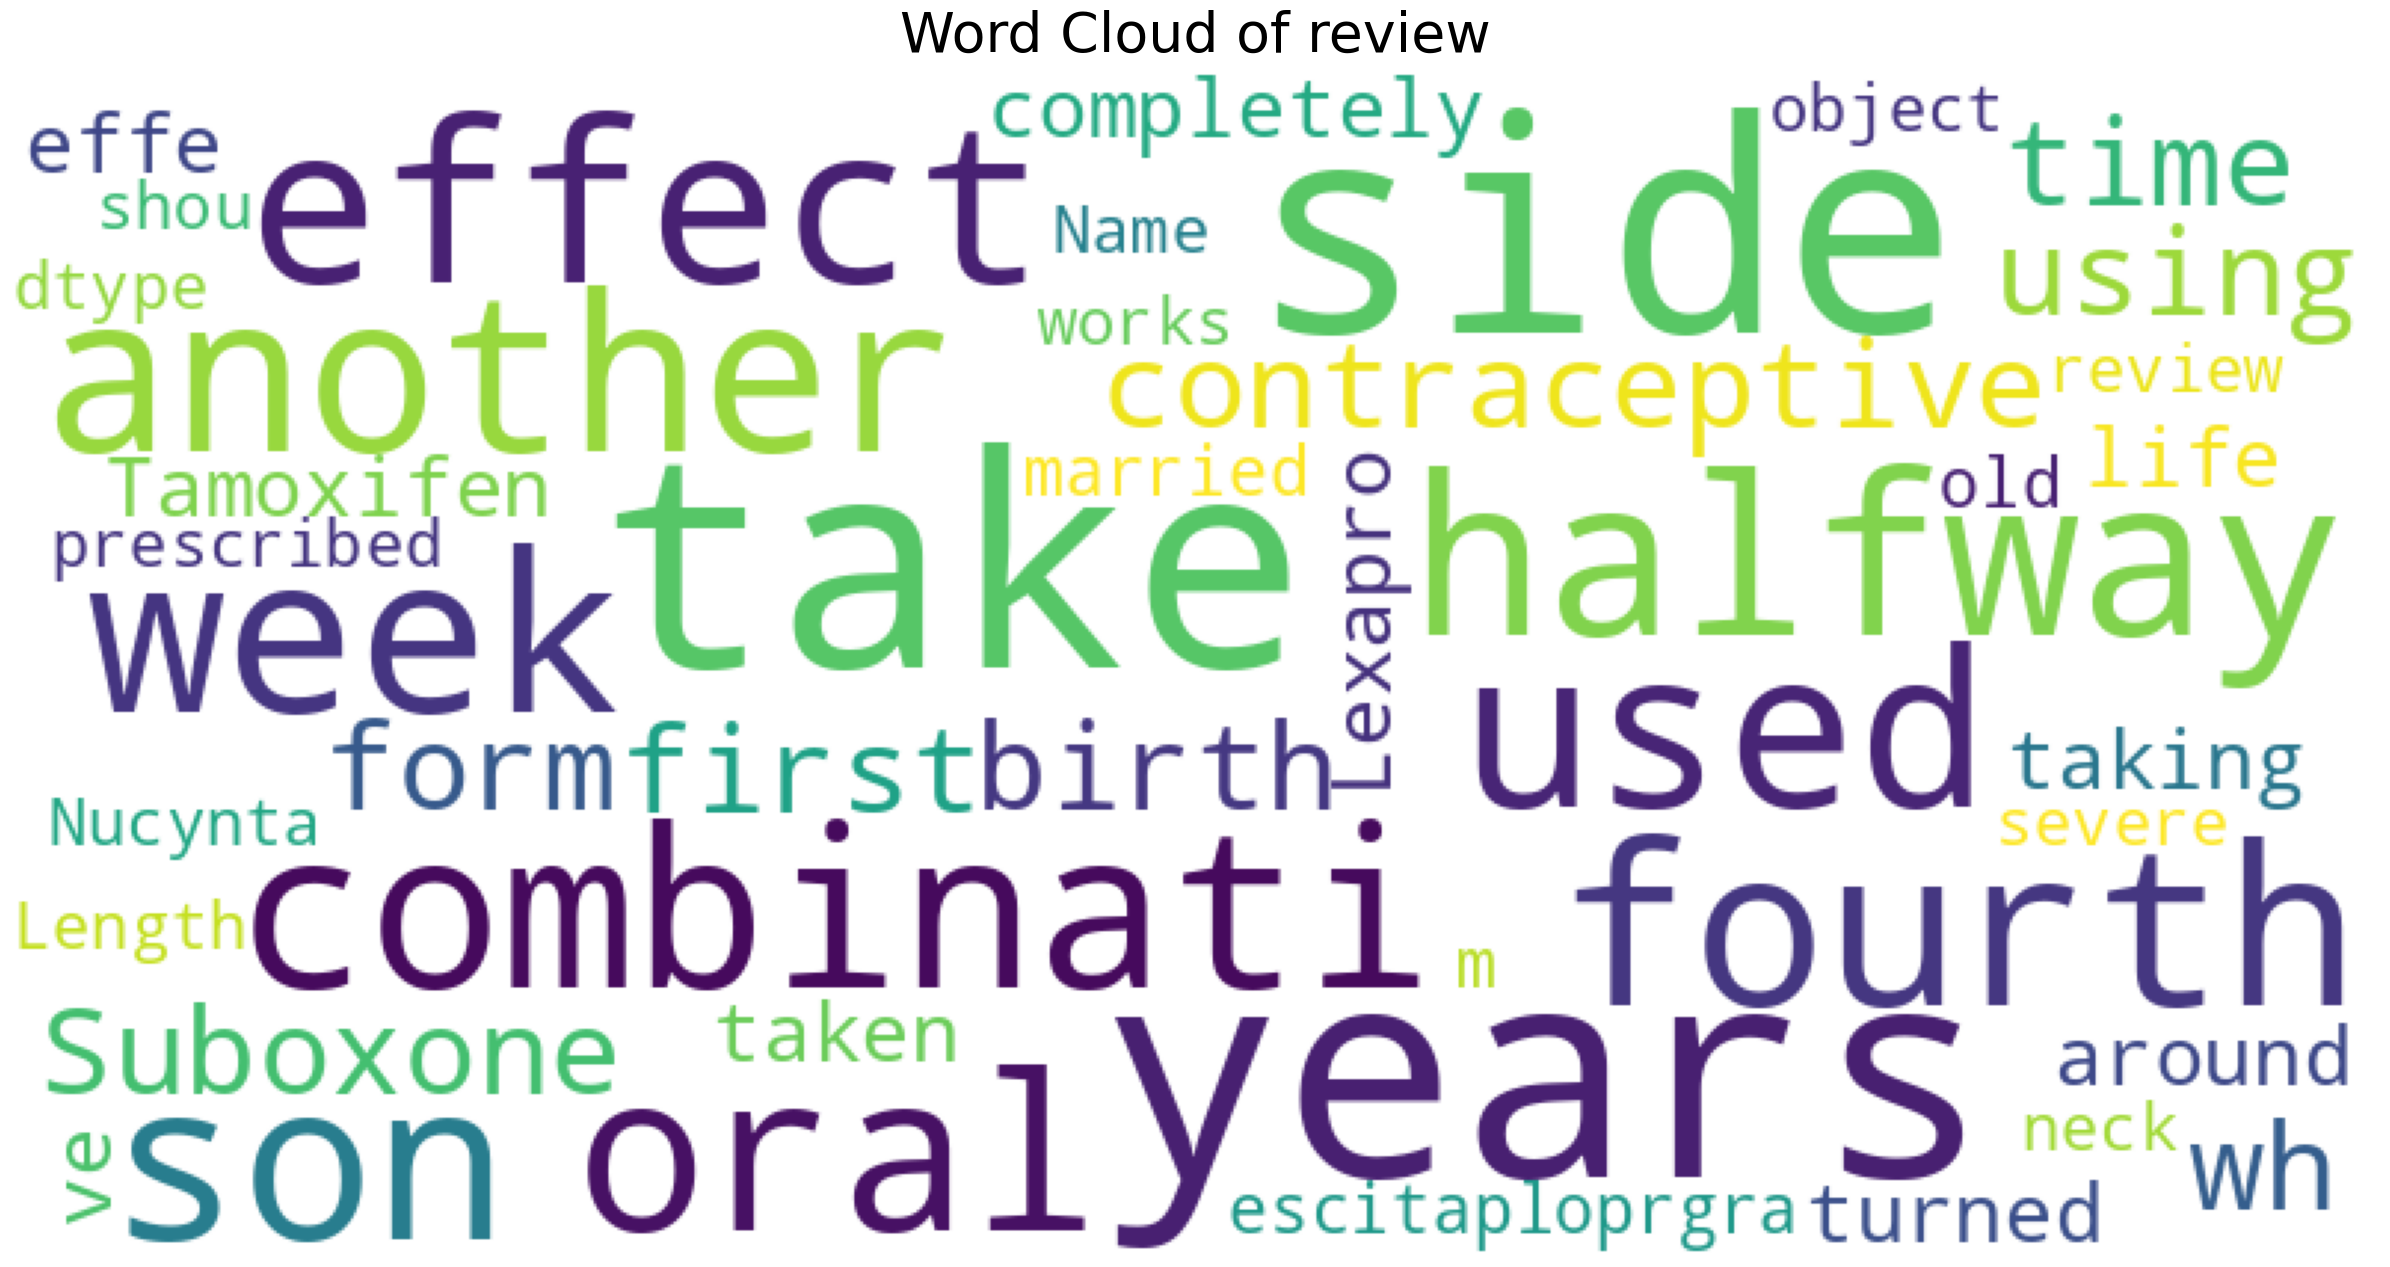

In [16]:
#https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc kernel
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0),
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=800,
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

plot_wordcloud(df_all["review"], title="Word Cloud of review")

Next, we will classify 1 ~ 5 as negative, and 6 ~ 10 as positive, and we will check through 1 ~ 4 grams which corpus best classifies emotions.

In [17]:
from collections import defaultdict
df_all_6_10 = df_all[df_all["rating"]>5]
df_all_1_5 = df_all[df_all["rating"]<6]

Next, we will look for relationship between rating and weather. First of all, we will count the number of ratings.

Text(0.5, 1.0, 'Count of rating values')

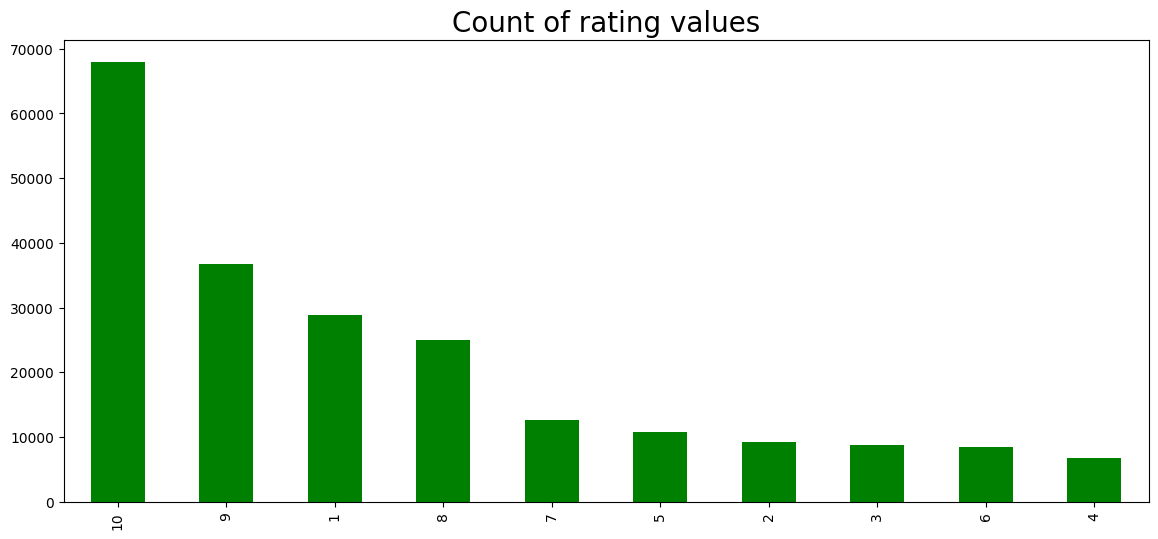

In [18]:
rating = df_all['rating'].value_counts().sort_values(ascending=False)
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Count of rating values", fontsize = 20)

Most people choose four values; 10, 9, 1, 8, and the number of 10 is more than twice as many as the others. With this, we can see that the percentage of positives is higher than negative, and people's reactions are extreme.

Next, we will check the number of reviews and percentage of ratings according to weather.

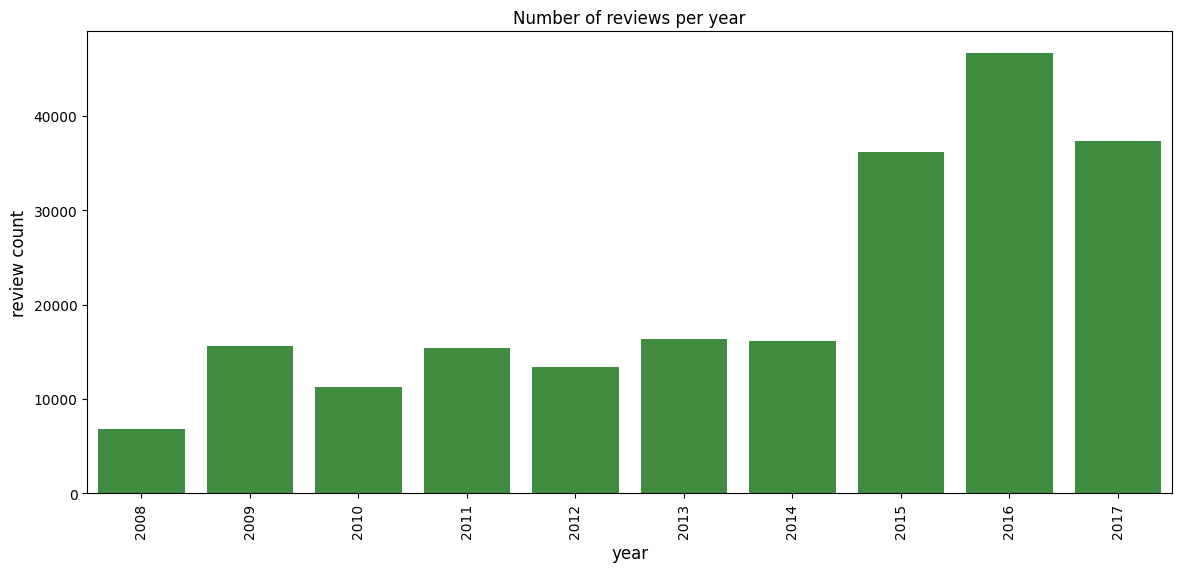

In [19]:
# Code in https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo
# SRK - Simple Exploration Notebook

cnt_srs = df_all['date'].dt.year.value_counts().sort_index()

plt.figure(figsize=(14,6))
sns.barplot(
    x=cnt_srs.index,
    y=cnt_srs.values,
    alpha=0.8,
    color='green'
)
plt.xticks(rotation='vertical')
plt.xlabel('year', fontsize=12)
plt.ylabel('review count', fontsize=12)
plt.title("Number of reviews per year")
plt.show()


Text(0.5, 1.0, 'Mean rating in year')

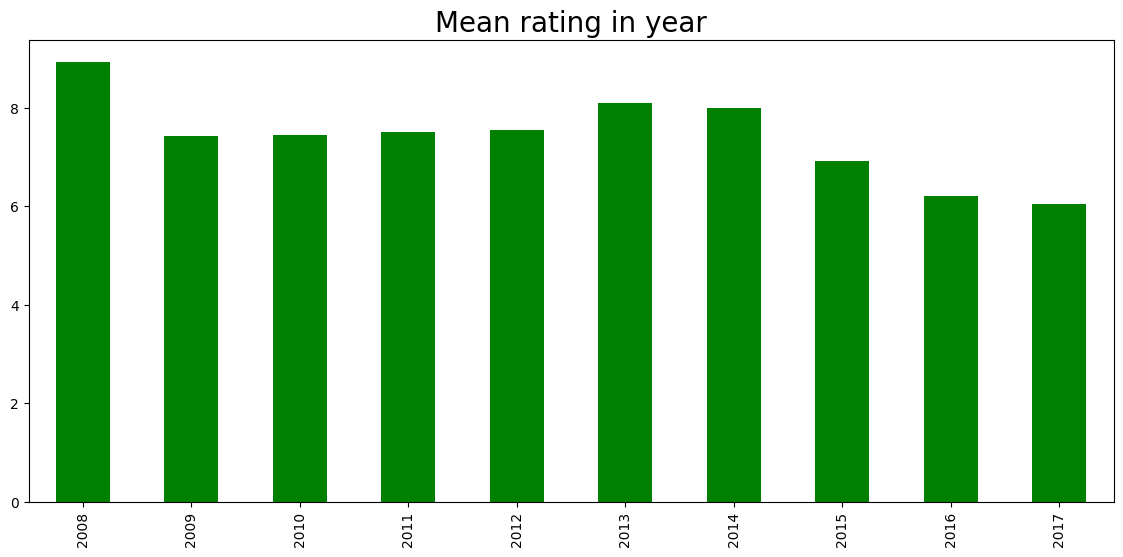

In [20]:
df_all['year'] = df_all['date'].dt.year
rating = df_all.groupby('year')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in year", fontsize = 20)

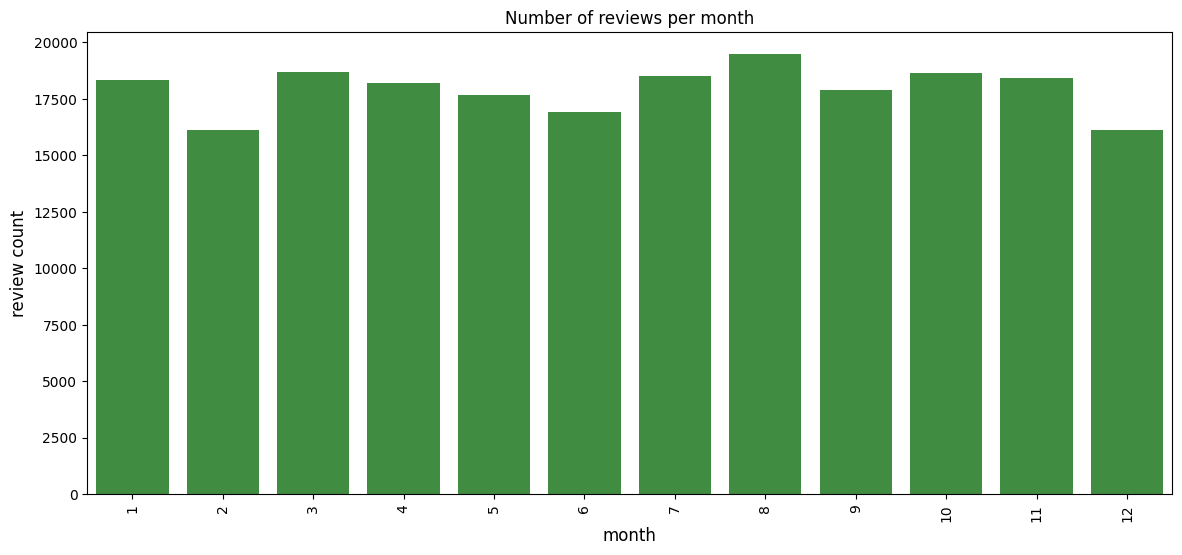

In [21]:
# Code in https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo
# SRK - Simple Exploration Notebook

cnt_srs = df_all['date'].dt.month.value_counts().sort_index()

plt.figure(figsize=(14,6))
sns.barplot(
    x=cnt_srs.index,
    y=cnt_srs.values,
    alpha=0.8,
    color='green'
)
plt.xticks(rotation='vertical')
plt.xlabel('month', fontsize=12)
plt.ylabel('review count', fontsize=12)
plt.title("Number of reviews per month")
plt.show()

Text(0.5, 1.0, 'Mean rating in month')

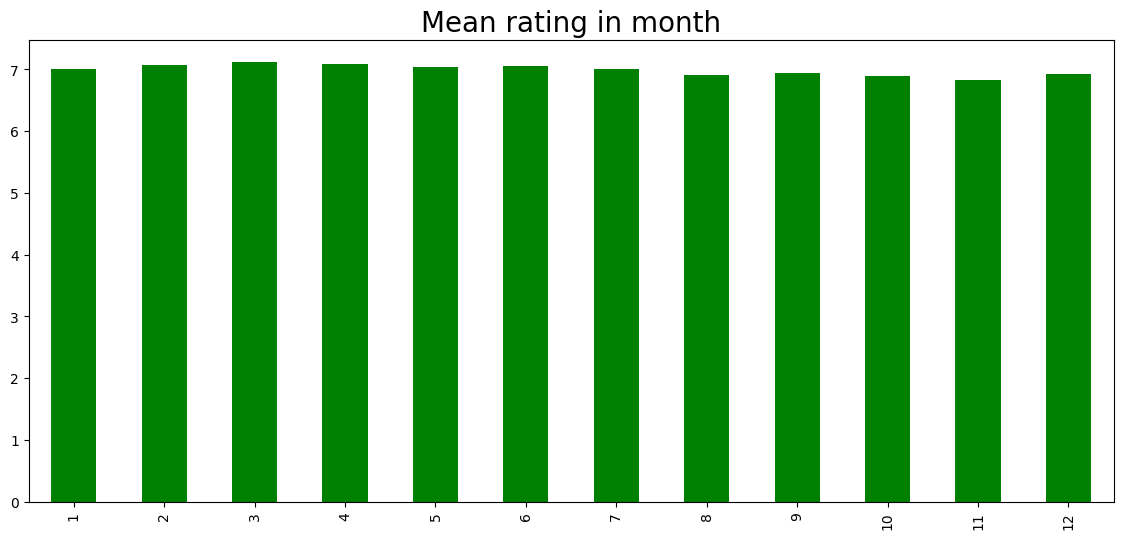

In [22]:
df_all['month'] = df_all['date'].dt.month
rating = df_all.groupby('month')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in month", fontsize = 20)

Interestingly, you can see that the average rating differs by year, but it is similar by month.

Text(0.5, 1.0, 'Mean rating in day')

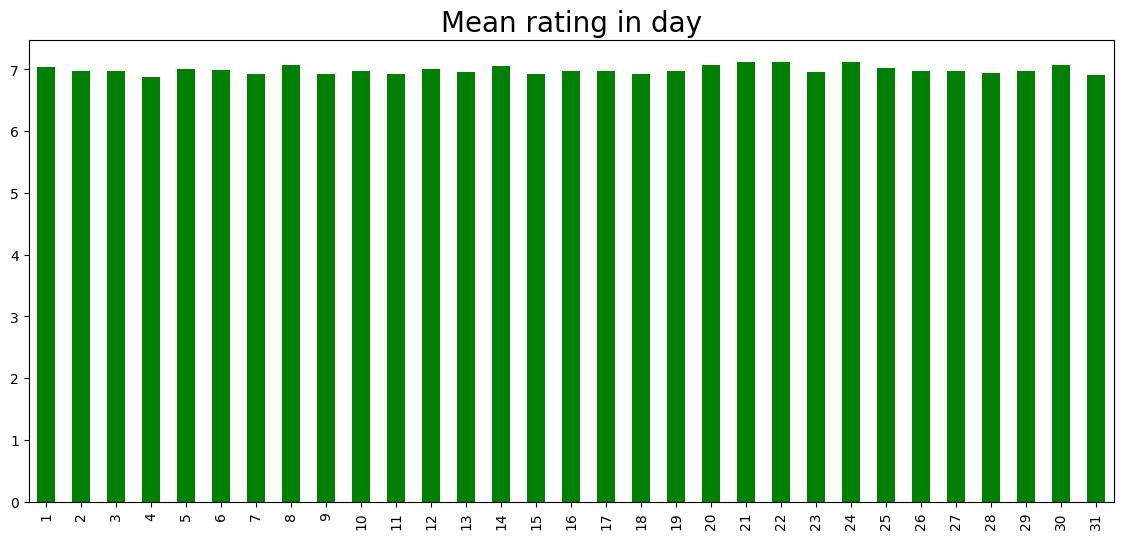

In [23]:
df_all['day'] = df_all['date'].dt.day
rating = df_all.groupby('day')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in day", fontsize = 20)

We checked whether the day of the week affects the rating like salary day, but it does not make a big difference.

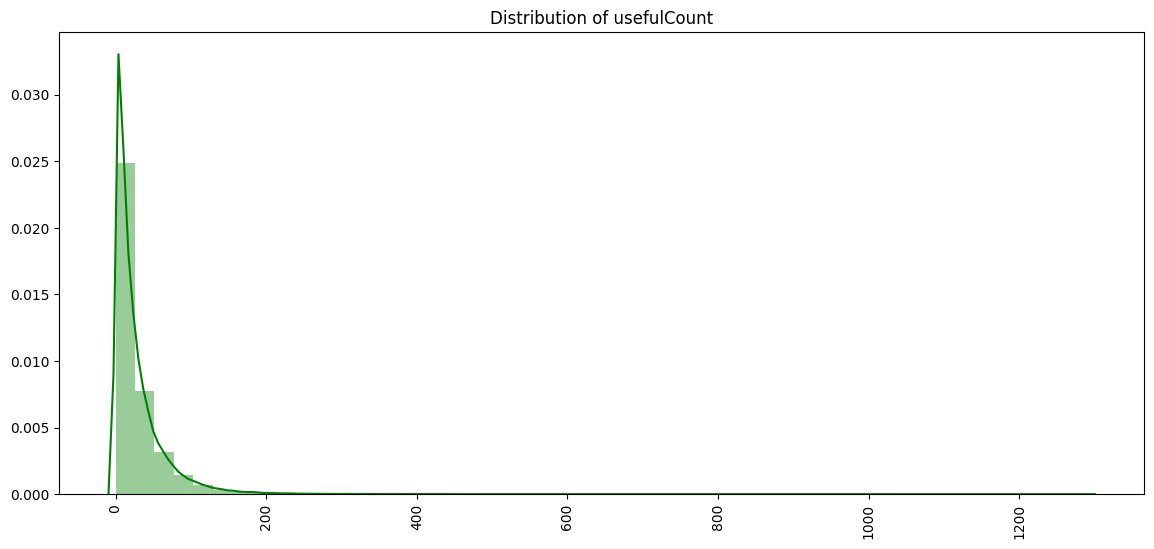

In [24]:
plt.figure(figsize=(14,6))
sns.distplot(df_all["usefulCount"].dropna(),color="green")
plt.xticks(rotation='vertical')
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Distribution of usefulCount")
plt.show()

In [25]:
df_all["usefulCount"].describe()

,usefulCount
count,215063.000000
mean,28.001004
std,36.346069
min,0.000000
25%,6.000000
50%,16.000000
75%,36.000000
max,1291.000000


If you look at the distribution of usefulCount, you can see that the difference between minimum and maximum is 1291, which is high. In addition, the deviation is huge, which is 36. The reason for this is that the more drugs people look for, the more people read the review no matter their contents are good or bad, which makes the usefulcount very high. So when we create the model, we will normalize it by conditions, considering people's accessibility.

### 1.3 Missing value

Text(0.5, 1.0, 'Total Missing Value ')

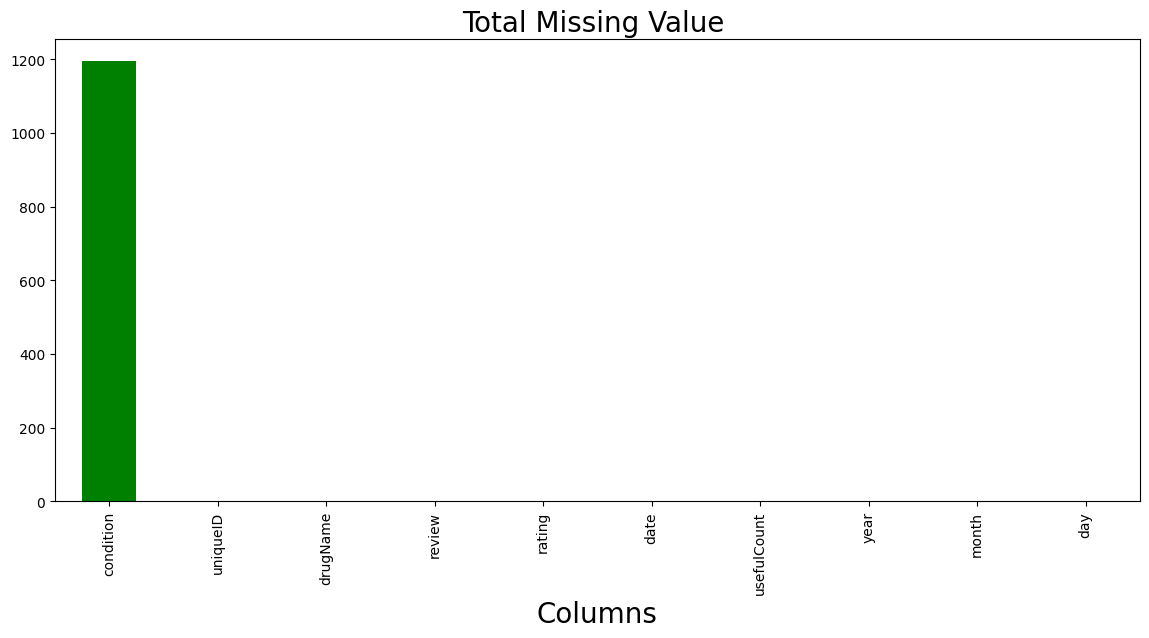

In [26]:
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

In [27]:
print("Missing value (%):", 1200/df_all.shape[0] *100)

Missing value (%): 0.5579760349292998


We will delete because the percentage is lower than 1%.

## 2. Date Preprocessing

### 2.1. Missing Values Removal

In [28]:
df_train = df_train.dropna(axis=0)
df_test = df_test.dropna(axis=0)

Text(0.5, 1.0, 'Total Missing Value ')

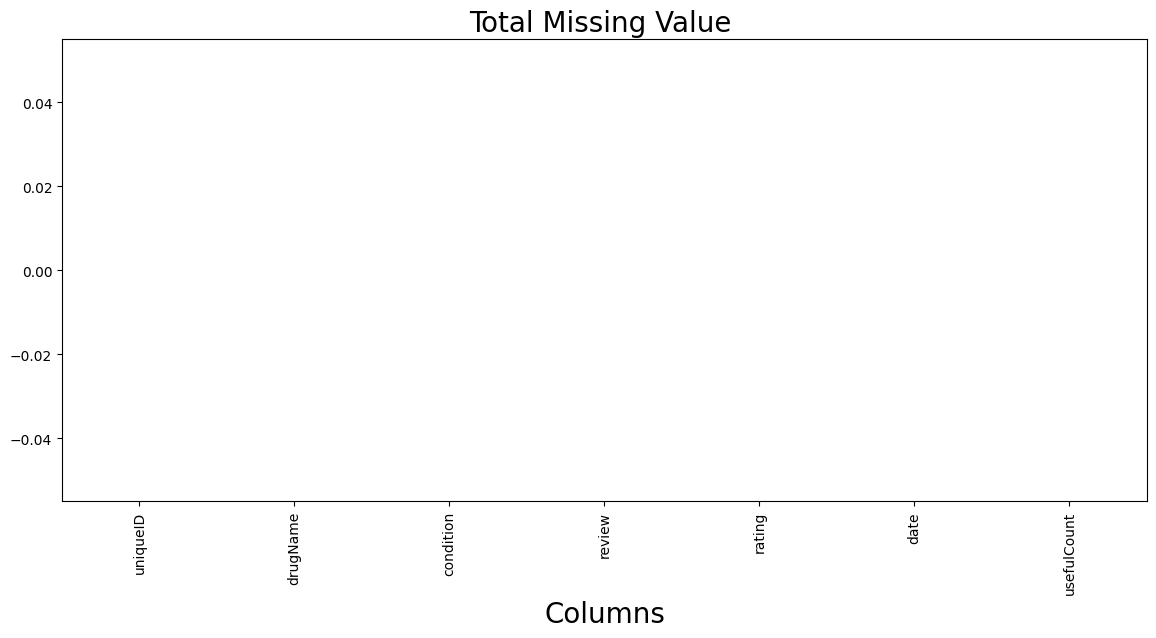

In [29]:
df_all = pd.concat([df_train,df_test]).reset_index()
del df_all['index']
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

### 2.2 Condition Preprocessing

We will delete the sentences with the form above.

In [30]:
all_list = set(df_all.index)
span_list = []
for i,j in enumerate(df_all['condition']):
    if '</span>' in j:
        span_list.append(i)

In [31]:
new_idx = all_list.difference(set(span_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

Next, we will delete conditions with only one drug.

In [32]:
df_condition = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drugName
816,Mumps Prophylaxis,1
817,Muscle Twitching,1
818,Myotonia Congenita,1
819,mulation) (phenylephrine),1
820,t Pac with Cyclobenzaprine (cyclobenzaprine),1
821,tic (mycophenolic acid),1
822,unctional Gastric Disorde,1
823,ungal Infection Prophylaxis,1
824,ungal Pneumonia,1
825,Hypopituitarism,1


In [33]:
df_condition_1 = df_condition[df_condition['drugName']==1].reset_index()
df_condition_1['condition'][0:10]

,condition
0,Acute Otitis Externa
1,Aggressive Behavi
2,Amyotrophic Lateral Sclerosis
3,ge (amlodipine / valsartan)
4,ge HCT (amlodipine / hydrochlorothiazide / val...
5,llicular Lymphoma
6,mance Anxiety
7,min / pioglitazone)
8,min / rosiglitazone)
9,min / saxagliptin)


In [34]:
all_list = set(df_all.index)
condition_list = []
for i,j in enumerate(df_all['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)

new_idx = all_list.difference(set(condition_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

### 2.3 Review Preprocessing

In [35]:
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

- \r\n : we need to convert html grammer
- ... , &#039; : deal with not alphabet

In [36]:
nltk.download('stopwords')
stops = set(stopwords.words('english'))
#stops

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


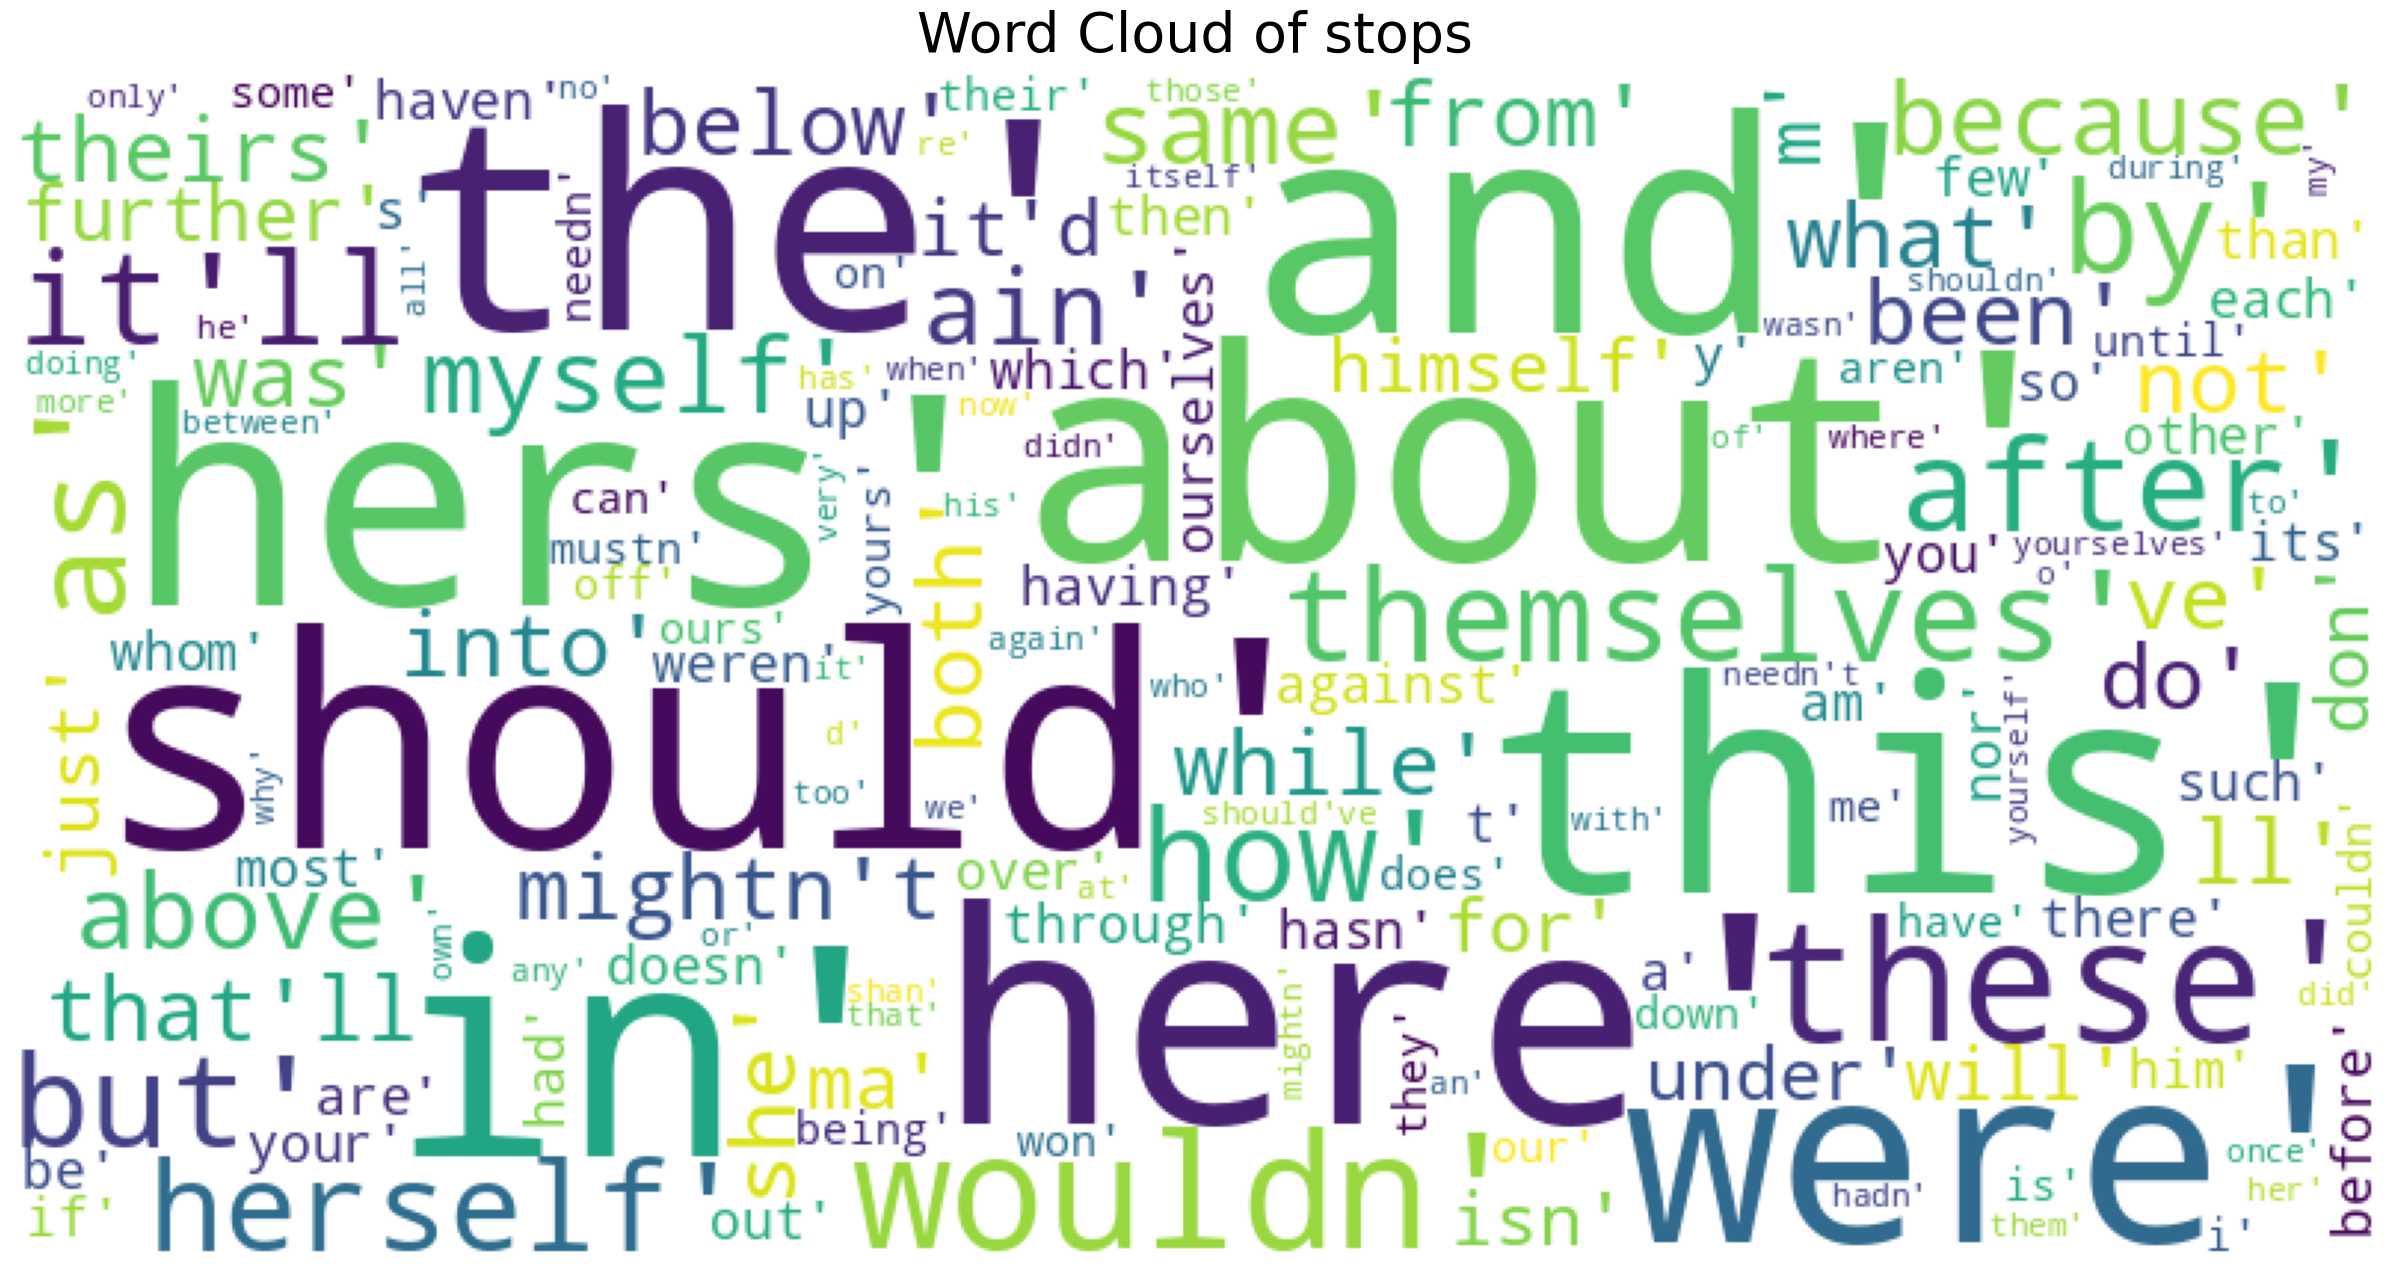

In [37]:
#https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc kernel
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0),
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=800,
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

plot_wordcloud(stops, title="Word Cloud of stops")

First, let's see what words are used as stopwords. There are many words that include not, like needn't. These words are key parts of emotional analysis, so we will remove them from stopwords.

In [38]:
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [39]:
!pip install tensorflow

In [40]:
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers


In [41]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))

In [42]:
%time df_all['review_clean'] = df_all['review'].apply(review_to_words)

CPU times: user 2min 9s, sys: 387 ms, total: 2min 9s
Wall time: 2min 30s


## 3. Model

### 3.1. Deep Learning Model Using N-gram

In [43]:
# Make a rating
df_all['sentiment'] = df_all["rating"].apply(lambda x: 1 if x > 5 else 0)

In [44]:
df_train, df_test = train_test_split(df_all, test_size=0.33, random_state=42)

In [45]:
from sklearn.pipeline import Pipeline


# === BERT ===
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

# Load BERT model and tokenizer
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [46]:
# Tokenize input texts and convert to embeddings
from tqdm import tqdm

def get_bert_embeddings(texts, max_len=128, batch_size=64):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting BERT features"):
        batch_texts = texts[i:i+batch_size].tolist()
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=max_len, return_tensors="tf")
        outputs = bert_model(inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
        embeddings.append(batch_embeddings)
    return tf.concat(embeddings, axis=0)


import os
import numpy as np
import tensorflow as tf

def save_or_load_bert_features(texts, path, desc=""):
    if os.path.exists(path):
        print(f"📂 {desc} - Loading cached BERT features from {path}...")
        return tf.convert_to_tensor(np.load(path))
    else:
        print(f"🧠 {desc} - Extracting BERT features, please wait...")
        features = get_bert_embeddings(texts)
        np.save(path, features.numpy())
        return features

df_train_full = df_train.copy()
df_test_full = df_test.copy()

df_train_full = df_train_full[df_train_full["review"].notnull() & df_train_full["sentiment"].notnull()]
df_test_full = df_test_full[df_test_full["review"].notnull() & df_test_full["sentiment"].notnull()]

train_data_features = save_or_load_bert_features(df_train_full["review"], "../train_bert_features.npy", "Train")
test_data_features = save_or_load_bert_features(df_test_full["review"], "../test_bert_features.npy", "Test")


🧠 Train - Extracting BERT features, please wait...


Extracting BERT features: 100%|██████████| 2220/2220 [19:24<00:00,  1.91it/s]


🧠 Test - Extracting BERT features, please wait...


Extracting BERT features: 100%|██████████| 1094/1094 [09:24<00:00,  1.94it/s]


In [47]:
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences


# 0. Package
import numpy as np
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import random

# 1. Dataset
y_train = df_train_full['sentiment']
y_test = df_test_full['sentiment']
solution = y_test.copy()


# 2. Model Structure for BERT embeddings
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(768,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# 3. Model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,561 (385.00 KB)

 Trainable params: 98,561 (385.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7716 - loss: 0.4763
Epoch 2/10
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8086 - loss: 0.4182
Epoch 3/10
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8124 - loss: 0.4085
Epoch 4/10
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8162 - loss: 0.4030
Epoch 5/10
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8188 - loss: 0.3958
Epoch 6/10
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8241 - loss: 0.3903
Epoch 7/10
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8245 - loss: 0.3871
Epoch 8/10
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8255 - loss: 0.3835
Epoch 9/10
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8271 - loss: 0.3814
Epoch 10/10
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8282 - loss: 0.3779


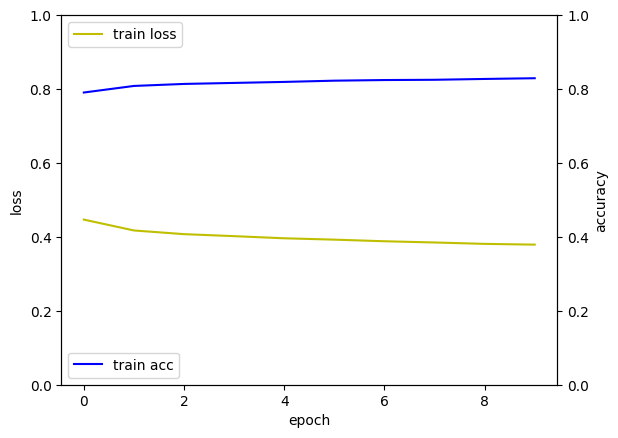

In [48]:
# Commented out IPython magic to ensure Python compatibility.
# 4. Train model
hist = model.fit(train_data_features, y_train, epochs=10, batch_size=64)

# 5. Traing process

import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()



In [49]:
# 6. Evaluation
loss_and_metrics = model.evaluate(test_data_features, y_test, batch_size=32)
print('loss_and_metrics : ' + str(loss_and_metrics))

sub_preds_deep = model.predict(test_data_features,batch_size=32)

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8289 - loss: 0.3796
loss_and_metrics : [0.3792473375797272, 0.829103410243988]
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


As mentioned earlier, we have normalized usefulCount by condition to solve the problem that usefulCount shows bias depending on condition. You can then add three predicted emotion values and multiply them by the normalized usefulCount to get the predicted value.

Now, we can recommend drug by condition in order of final predicted value.

In [50]:
def userful_count(data):
    grouped = data.groupby(['condition']).size().reset_index(name='user_size')
    data = pd.merge(data,grouped,on='condition',how='left')
    return data
#___________________________________________________________
df_test =  userful_count(df_test)
df_test['usefulCount'] = df_test['usefulCount']/df_test['user_size']

In [51]:
df_test['deep_pred'] = sub_preds_deep


df_test['total_pred'] = df_test['deep_pred']*df_test['usefulCount']

In [52]:
df_test = df_test.groupby(['condition','drugName']).agg({'total_pred' : ['mean']})
df_test

total_pred
                                                       mean
condition                drugName                          
ADHD                     Adderall                  0.028706
                         Adderall XR               0.018133
                         Adzenys XR-ODT            0.004290
                         Amantadine                0.004019
                         Amphetamine               0.005126
...                                                     ...
moterol)                 Arformoterol              0.918395
                         Budesonide / formoterol   0.944729
von Willebrand's Disease Stimate                   2.473914
zen Shoulde              Nabumetone               12.807158
                         Naproxen                  0.277213

[5773 rows x 1 columns]

In [54]:
# 2. Rename the column
df_test = df_test.groupby(['condition', 'drugName'])['total_pred'].mean().reset_index()
df_test.columns = ['condition', 'drugName', 'total_pred']

# Save as CSV for easy manual viewing
df_test.to_csv("../final_predictions.csv", index=False)

# Save as PKL for front-end call
df_test.to_pickle("../final_predictions.pkl")

## 4. Result

Our team set the topic as recommending the right medicine for the patient's condition with reviews and proceeded the project according to the topic with the data exploration, data preprocessing and modeling. In the data exploration section, we looked at the forms of data using visualization techniques and statistical techniques. We also looked for n-grams that can best represent emotions, and the relationship with date and rating. The next step was to preprocess the data according to the topic we set, such as removing the condition that has only one drug for recommendation. In the process of modeling, we used deep learning model with n-gram, and additionally used a machine learning model called Lightgbm to overcome the limitation of natural language processing. In addition, we conducted emotional analysis using emotional word dictionary to overcome limitations of package formed with movie data. In addition, we nomalized usefulcount by condition for better reliability. These steps allowed us to calculate the final predicted value and recommend the appropriate drug for each condition according to the order of the value.

## 5. Limitations

In conclusion, these are the limitations we had during the project.

1. Sentiment analysis using sentiment word dictionary has low reliability when the number of positive and negative words is small. For example, if there are 0 positive words and 1 negative word, it is classified as negative. Therefore, if the number of sentiment words is 5 or less, we could exclude the observations.
2. To ensure the reliability of the predicted values, we normalized usefulCount and multiplied it to the predicted values. However, usefulCount may tend to be higher for older reviews as the number of cumulated site visitors increases. Therefore, we should have also considered time when normalizing usefulCount.
3. If the emotion is positive, the reliability should be increased to the positive side, and if it is negative, the reliability should be increased toward the negative side. However, we simply multiplied the usefulCount for reliability and did not consider this part. So we should have multiplied considering the sign of usefulCount according to different kinds of emotion.


